# Dataset Preprocessing and Feature Extraction for the Toronto Emotional Speech Set (TESS)

### This notebook handles the preprocessing pipeline for the Toronto Emotional Speech Set (TESS).
It includes:
1.  **Data Loading & Statistics**: Analyzing file durations and sample rates.
2.  **Data Cleaning**: Removing silence and padding audio to a fixed length (3 seconds).
3.  **Feature Extraction**: Computing Mel Spectrograms and MFCCs.
4.  **Dataset Creation**: Saving the processed features into HDF5 (`.h5`) files for training, validation, and testing.

In [ ]:
import numpy as np
import os
import librosa as lr
import h5py
import soundfile as sf
import pandas as pd
import re
from scipy.signal import savgol_filter
import shutil
import random
import matplotlib.pyplot as plt
import librosa.display

# Set seed for reproducibility
random.seed(42)

base_path = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == "Preprocessing_Feature_Extraction" else os.getcwd()

project_root = os.path.abspath(os.path.join(base_path, "../../")) 
audio_data_path = os.path.join(project_root, "data/TESS/")
audio_data_path_silence = os.path.join(project_root, "data/TESS/TESS_with_Silence/")

## Calculate database statistics

### Database Statistics
We iterate through all `.wav` files in the source directory to calculate the distribution of audio durations and verify the sample rate. This helps in deciding the fixed length for padding/truncating.

In [3]:
# data=[]
file_names=[]
samples=[]
durations=[]
pre_emphasis=0.96
n_fft=4096
n_mfcc=40
hop_length=int(4096/2)
n_mels=40
for path in os.listdir(audio_data_path):
    if path[-3:]=="wav":
        file_path=os.path.join(audio_data_path, path)
        file_names.append(path)
        y, sr = sf.read(file_path)
        # print(sr)
        samples.append(y)
        duration=len(y)/sr
        durations.append(duration)

In [4]:
print(f'Es sind {len(file_names)} Dateien geladen worden.')
print(f'Die Längste Datei ist {np.max(durations):.3f} Sekunden und die kürzeste {np.min(durations):.3f} Sekunden lang. Durchschnittlich sind die Dateien {np.mean(np.array(durations)):.3f} Sekunden lang.')
print(f'Die Samplerate ist {sr}.')

Es sind 2800 Dateien geladen worden.
Die Längste Datei ist 2.985 Sekunden und die kürzeste 1.254 Sekunden lang. Durchschnittlich sind die Dateien 2.055 Sekunden lang.
Die Samplerate ist 24414.


## Count emotions

### Emotion Distribution
We count the occurrences of each emotion category (Angry, Disgust, Fear, Happy, Neutral, Pleasant Surprise, Sad) to ensure the dataset is balanced.

In [5]:
def count_emotions(filenames):
    disgust, angry, fear, happy, neutral, ps, sad = 0,0,0,0,0,0,0
    for filename in filenames:
        if "disgust" in filename:
            disgust+=1
        if "angry" in filename:
            angry+=1
        if "fear" in filename:
            fear+=1
        if "happy" in filename:
            happy+=1
        if "neutral" in filename:
            neutral+=1
        if "ps" in filename:
            ps+=1
        if "sad" in filename:
            sad+=1
    return np.array([disgust, angry, fear, happy, neutral, ps, sad])

[400 400 400 400 400 400 400]


In [6]:
print(count_emotions(file_names))

[400 400 400 400 400 400 400]


## Zero padding to three seconds and filtering

### Silence Removal and Padding
To ensure uniform input for the model, we:
1.  Remove silence from the audio clips.
2.  Pad or truncate them to a fixed length of **3 seconds**.
3.  Apply a Savitzky-Golay filter for smoothing.
The processed files are saved to a new directory: `TESS_with_Silence_Filtered`.

In [ ]:
def add_silence_and_save(y, sr, folder_path, file_name):
    file_path=os.path.join(folder_path, file_name)
    if len(y)/sr<=3:
        left_array_length = int((sr*3-len(y))/2)
        right_array_length = sr*3-len(y)-left_array_length
        left_array = np.zeros(left_array_length)
        right_array = np.zeros(right_array_length)
        new_array = np.concatenate((left_array,y), axis=0)
        samples = np.concatenate((new_array,right_array), axis=0)
        samples_filtered = savgol_filter(samples, 9, 2)
        sf.write(file_path, samples_filtered, sr, subtype='PCM_16')

# Create or change folder path
folder_path = os.path.join(project_root, "data/TESS/TESS_with_Silence_Filtered/")
shutil.rmtree(folder_path)
os.makedirs(folder_path)
for i in range(0, len(samples)):
    add_silence_and_save(samples[i], sr, folder_path, file_names[i])

### Create dictionary

### Metadata Dictionary Creation
We create a structured list of dictionaries containing file paths, emotion labels, and speaker IDs. This serves as a metadata index for the dataset.

In [11]:
# data=[]
file_names=[]
speaker_id=[]

speaker_emotion=[]

classes = ["angry", "disgust", "fear", "happy", "neutral", "pleasant-surprised", "sad"]
speaker=["OAF", "YAF"]
classes_idx=[]
objs=[]
c_idx=0
idx=0

for c in classes:
    # print(idx)
    for path in os.listdir(audio_data_path):
        if path[-3:]=="wav":
            file_path=os.path.join(audio_data_path, path)
            file_names.append(path)
            c_idx=0
            saved_emotion=""
            for emotion_name in classes:
                match = re.search(emotion_name, path)
                if match:
                    saved_emotion=c_idx
                else:
                    None
                c_idx+=1
            if path[:3]=="OAF":
                speaker_id=0
            if path[:3]=="YAF":
                speaker_id=1
            
            dict_obj = {
                "path":file_path,
                "emotion":saved_emotion,
                "speaker_id":speaker_id
            }
            objs.append(dict_obj)

print(objs[0])

{'path': '../../../data/TESS/YAF_wire_happy.wav', 'emotion': 3, 'speaker_id': 1}


## Helper functions

### Visualization Helper Functions
Functions to plot **Log Mel Spectrograms** and **MFCCs** (Mel Frequency Cepstral Coefficients) for visual inspection of the features.

In [12]:
def get_class(filename):
        if "disgust" in filename:
            return "Disgust"
        if "angry" in filename:
            return "Angry"
        if "fear" in filename:
            return "Fear"
        if "happy" in filename:
            return "Happy"
        if "neutral" in filename:
            return "Neutral"
        if "ps" in filename:
            return "Pleasant Surprise"
        if "sad" in filename:
            return "Sad"
        
def plot_mel_spectrogram(mel_spec_log, path):
    title_add = get_class(path[:-4])
    plt.figure()
    img = lr.display.specshow(mel_spec_log, x_axis='time')
    plt.colorbar(img)
    title_log_mel = f"Log Mel Spectrogram [{path[2:5]}]: {title_add}"
    plt.title(title_log_mel)
    plt.show()

def plot_mfcc(mfcc, path):
    title_add = get_class(path[:-4])
    plt.figure()
    img = lr.display.specshow(mfcc, x_axis='time')
    plt.colorbar(img)
    title_mfcc = f"Mel Frequency Cepstral Coefficient [{path[2:5]}]: {title_add}"
    plt.title(title_mfcc)
    plt.ylabel('Frequency Bands (Mel-Scale)')
    plt.show()

## Test feature extraction strategy

### Feature Extraction Test
We run a test extraction on a single file to verify the parameters for STFT, Mel Spectrogram, and MFCC generation before processing the entire dataset.

In [ ]:
def test_feature_extraction(audio_data_path, n_fft=4096, hop_length=int(4096/2), n_mels=40, pre_emphasis=0.96):
    file_path = os.path.join(audio_data_path)
    for file in os.listdir(audio_data_path):
        file_path = os.path.join(audio_data_path, file)
        if os.path.isfile(file_path):
            if file_path[-3:]=="wav":
                y, sr = sf.read(file_path)
                print(sr)
                emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
                # Calculate magnitude of STFT first
                stft = lr.stft(emphasized_signal, n_fft=n_fft, hop_length=hop_length)
                mel_spec = lr.feature.melspectrogram(S=stft, n_mels=n_mels)
                mfcc = lr.feature.mfcc(S=lr.power_to_db(mel_spec), n_mfcc=40)
                mel = lr.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, norm=2, window='hamming')
                mel = np.array(lr.power_to_db(mel, ref=np.max).astype(np.float32))      
                mel_result = np.concatenate((mel, mfcc), axis=0)
                print(mel.shape, file_path)
                plot_mel_spectrogram(mel, file_path)
                print(mfcc.shape, file_path)
                plot_mfcc(mfcc, file_path)
                break


24414
(40, 25) ../../../data/TESS/YAF_wire_happy.wav


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


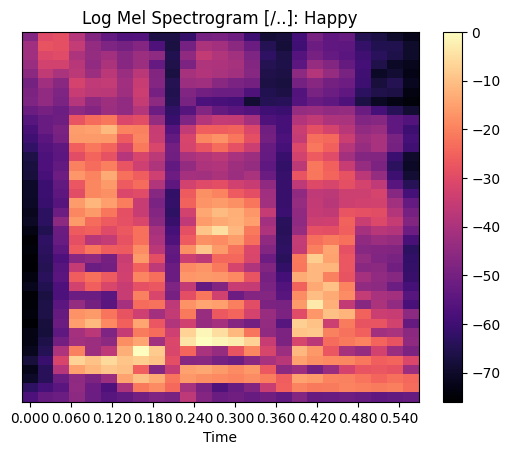

(40, 25) ../../../data/TESS/YAF_wire_happy.wav


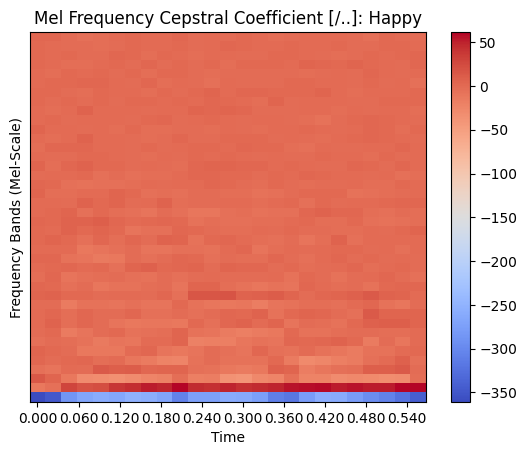

In [14]:
test_feature_extraction(audio_data_path)

## H5 dataset creation

### HDF5 Dataset Generation
This is the core processing function. It:
1.  Iterates through the Train, Validation, and Test splits.
2.  Extracts Mel Spectrograms and MFCCs for each file.
3.  Saves the features and labels into compressed `.h5` files (`train_TESS.h5`, `valid_TESS.h5`, `test_TESS.h5`).

In [ ]:
def create_features_dataset(dataset_name, audio_data_path, train_list, valid_list, test_list, n_fft=4096, hop_length=int(4096/2), n_mels=40, pre_emphasis=0.96):
    def get_class(filename):
        if "disgust" in filename:
            return 0
        if "angry" in filename:
            return 1
        if "fear" in filename:
            return 2
        if "happy" in filename:
            return 3
        if "neutral" in filename:
            return 4
        if "ps" in filename:
            return 5
        if "sad" in filename:
            return 6
    # assert dataset_name[-3:]!=".h5"
    # dataset = h5py.File(dataset_name, mode="w", libver="latest")
    output_dir = os.path.join(base_path, "Dataset")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    train_dataset = h5py.File(os.path.join(output_dir, "train_"+dataset_name), mode="w", libver="latest")
    for file in train_list:
        file_path = os.path.join(audio_data_path, file)
        if os.path.isfile(file_path):
            if file_path[-3:]=="wav":
                y, sr = lr.load(file_path)
                emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
                stft = lr.stft(emphasized_signal, n_fft=n_fft, hop_length=hop_length)
                mel_spec = lr.feature.melspectrogram(S=stft, n_mels=n_mels)
                mfcc = lr.feature.mfcc(S=lr.power_to_db(mel_spec), n_mfcc=40)
                mel = lr.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, norm=2, window='hamming')
                mel = np.array(lr.power_to_db(mel, ref=np.max).astype(np.float32))      
                mel_result = np.concatenate((mel, mfcc), axis=0)
                filename = file.replace(".wav", "_")
                file_class = get_class(filename)
                f = [mel_result]
                idx=0
                for _f in f:
                    filename += str(idx)
                    idx+=1
                    h5spec = train_dataset.create_dataset(filename, data=_f)
                    h5spec.attrs["class_label"] = file_class
                    # i+=1
    train_dataset.close()
    valid_dataset = h5py.File(os.path.join(output_dir, "valid_"+dataset_name), mode="w", libver="latest")
    for file in valid_list:
        file_path = os.path.join(audio_data_path, file)
        if os.path.isfile(file_path):
            if file_path[-3:]=="wav":
                y, sr = lr.load(file_path)
                emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
                stft = lr.stft(emphasized_signal, n_fft=n_fft, hop_length=hop_length)
                mel_spec = lr.feature.melspectrogram(S=stft, n_mels=n_mels)
                mfcc = lr.feature.mfcc(S=lr.power_to_db(mel_spec), n_mfcc=n_mfcc)
                mel = lr.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, norm=2, window='hamming')
                mel = np.array(lr.power_to_db(mel, ref=np.max).astype(np.float32))      
                mel_result = np.concatenate((mel, mfcc), axis=0)
                filename = file.replace(".wav", "_")
                file_class = get_class(filename)
                f = [mel_result]
                idx=0
                for _f in f:
                    filename += str(idx)
                    idx+=1
                    h5spec = valid_dataset.create_dataset(filename, data=_f)
                    h5spec.attrs["class_label"] = file_class
    valid_dataset.close()
    test_dataset = h5py.File(os.path.join(output_dir, "test_"+dataset_name), mode="w", libver="latest")
    for file in test_list:
        file_path = os.path.join(audio_data_path, file)
        if os.path.isfile(file_path):
            if file_path[-3:]=="wav":
                y, sr = lr.load(file_path)
                emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
                # Calculate magnitude of STFT first
                stft = lr.stft(emphasized_signal, n_fft=n_fft, hop_length=hop_length)
                mel_spec = lr.feature.melspectrogram(S=stft, n_mels=n_mels)
                mfcc = lr.feature.mfcc(S=lr.power_to_db(mel_spec), n_mfcc=n_mfcc)
                mel = lr.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, norm=2, window='hamming')
                mel = np.array(lr.power_to_db(mel, ref=np.max).astype(np.float32))      
                mel_result = np.concatenate((mel, mfcc), axis=0)
                filename = file.replace(".wav", "_")
                file_class = get_class(filename)
                f = [mel_result]
                idx=0
                for _f in f:
                    filename += str(idx)
                    idx+=1
                    h5spec = test_dataset.create_dataset(filename, data=_f)
                    h5spec.attrs["class_label"] = file_class
    test_dataset.close()
    print("Train, valid and test dataset created")

### Name the dataset

In [ ]:
vers="TESS_mel_mfcc.txt"
versh="TESS_mel_mfcc.h5"

trainset="train_"+versh
testset="test_"+versh
validset="valid_"+versh
print(trainset)

### Delete dataset, when already created

In [ ]:
file_path1=os.path.join(os.getcwd(), trainset)
if os.path.isfile(file_path1):
    os.remove(file_path1)

file_path2=os.path.join(os.getcwd(), testset)
if os.path.isfile(file_path2):
    os.remove(file_path2)

file_path3=os.path.join(os.getcwd(), validset)
if os.path.isfile(file_path3):
    os.remove(file_path3)

## Randomization

## Data Splitting
We shuffle the dataset (with a fixed random seed for reproducibility) and split it into:
*   **Train**: 80%
*   **Validation**: 10%
*   **Test**: 10%

In [ ]:
file_list=os.listdir(audio_data_path_silence)
random.shuffle(file_list)

train_len = int(0.8 * len(file_list))
valid_len = int(0.1 * len(file_list)) 

train_list = file_list[:train_len]
valid_list = file_list[train_len:train_len+valid_len]
test_list = file_list[train_len+valid_len:]

## Create dataset

## Execute Processing
Run the full pipeline to generate the final HDF5 dataset files.

In [ ]:
create_features_dataset(versh, audio_data_path_silence, train_list, valid_list, test_list)